In [1]:
import tensorflow as tf
from tensorflow.keras import Model, models, layers
import matplotlib.pyplot as plt

In [2]:
image_size=(178,216)
batch_size=16
ds_path="C:/geetesh/aimldl/projects/denoiser/128xSkip/dataset"

In [3]:
train_ds=tf.keras.utils.image_dataset_from_directory(directory=ds_path,image_size=image_size,batch_size=batch_size,label_mode=None,validation_split=0.2,seed=42,subset='training')
val_ds=tf.keras.utils.image_dataset_from_directory(directory=ds_path,image_size=image_size,batch_size=batch_size,label_mode=None,validation_split=0.2,seed=42,subset='validation')

Found 202599 files belonging to 1 classes.
Using 162080 files for training.
Found 202599 files belonging to 1 classes.
Using 40519 files for validation.


In [4]:
train_ds=train_ds.map(lambda x:tf.cast(x, tf.float32)/255.)
val_ds=val_ds.map(lambda x:tf.cast(x, tf.float32)/255.)

In [5]:
#MAX_IMAGES = 100_000
#MAX_BATCHES = MAX_IMAGES // batch_size
#train_ds = train_ds.take(MAX_BATCHES)
#val_ds= val_ds.take(5000)

In [6]:
def add_noise(x, min_sigma=0.05, max_sigma=0.25):

    r = tf.random.uniform([])

    def gaussian_case():
        sigma = tf.random.uniform([], min_sigma, max_sigma)
        noise = tf.random.normal(tf.shape(x), 0.0, sigma)
        return tf.clip_by_value(x + noise, 0.0, 1.0)

    def spatial_gaussian_case():
        sigma = tf.random.uniform([], min_sigma, max_sigma)

        noise = tf.random.normal(tf.shape(x), 0.0, sigma)

        # smooth spatial mask (H, W, 1)
        weight = tf.image.resize(
            tf.random.uniform([16, 16, 1]),
            tf.shape(x)[:2],
            method="bilinear"
        )
        weight = weight / (tf.reduce_max(weight) + 1e-8)

        # boost spatial influence
        weight = tf.clip_by_value(weight * 1.5, 0.3, 1.0)

        weight = tf.repeat(weight, tf.shape(x)[-1], axis=-1)

        return tf.clip_by_value(x + noise * weight, 0.0, 1.0)

    def salt_pepper_case():
        # MUCH stronger salt & pepper
        p = tf.random.uniform([], 0.01, 0.05)  # 1% – 5%
        mask = tf.random.uniform(tf.shape(x)) < p
        sp = tf.cast(tf.random.uniform(tf.shape(x)) > 0.5, tf.float32)
        return tf.clip_by_value(tf.where(mask, sp, x), 0.0, 1.0)

    return tf.cond(
        r < 0.4,
        gaussian_case,
        lambda: tf.cond(r < 0.8, spatial_gaussian_case, salt_pepper_case)
    )


In [7]:
def get_pair(x,y=None):
    noisy=add_noise(x)
    noise=noisy-x
    return noisy,noise

In [8]:
def fix_size(x):
    x = tf.image.random_crop(x, size=[128, 128, 3])
    return x


In [9]:
train_ds = (
    train_ds.unbatch()
    .map(fix_size, num_parallel_calls=tf.data.AUTOTUNE)
    .map(get_pair, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

val_ds = (
    val_ds.unbatch()
    .map(fix_size, num_parallel_calls=tf.data.AUTOTUNE)
    .map(get_pair, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)


In [10]:
def psnr(true,pred):
    return tf.image.psnr(true,pred,max_val=1.0)

In [11]:
class ResidualBLock(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.conv1=layers.Conv2D(64,3,padding='same')
        self.relul=layers.ReLU()
        self.conv2=layers.Conv2D(64,3,padding='same')
    
    def call(self,x):
        skip=x
        x=self.conv1(x)
        x=self.relul(x)
        x=self.conv2(x)
        return x+skip

In [12]:
class RCNN(tf.keras.Model):
    def __init__(self,num_blocks=4):
        super().__init__()
        self.head=layers.Conv2D(64,kernel_size=(3,3),padding="same")
        self.relu=layers.ReLU()
        self.blocks=[ResidualBLock() for _ in range(num_blocks)]
        self.tail=layers.Conv2D(3,2,padding='same')
    def call(self,x):
        x=self.head(x)
        x=self.relu(x)
        for blocks in self.blocks:
            x=blocks(x)
        noise=self.tail(x)
        return noise

In [17]:
model = RCNN()
model.build((None, 128, 128, 3))
model.summary()


Model: "rcnn_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          multiple                  1792      
                                                                 
 re_lu_6 (ReLU)              multiple                  0         
                                                                 
 residual_b_lock_5 (Residual  multiple                 73856     
 BLock)                                                          
                                                                 
 residual_b_lock_6 (Residual  multiple                 73856     
 BLock)                                                          
                                                                 
 residual_b_lock_7 (Residual  multiple                 73856     
 BLock)                                                          
                                                            

In [18]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=tf.keras.losses.MeanAbsoluteError()
)

In [19]:
model.fit(train_ds,validation_data=val_ds,epochs=2)

Epoch 1/2
10130/10130 [==============================] - 2481s 245ms/step - loss: 0.0225 - val_loss: 0.0193
Epoch 2/2
10130/10130 [==============================] - 2476s 244ms/step - loss: 0.0183 - val_loss: 0.0175


In [20]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(5e-5),
    loss=tf.keras.losses.MeanAbsoluteError()
)

In [21]:
model.fit(train_ds,validation_data=val_ds,epochs=2)

Epoch 1/2
10130/10130 [==============================] - 2399s 237ms/step - loss: 0.0170 - val_loss: 0.0167
Epoch 2/2
 1578/10130 [===>..........................] - ETA: 31:19 - loss: 0.0167

KeyboardInterrupt: 

In [15]:
val_iter=iter(val_ds)
noisy,true_noise=next(val_iter)
pred_noise=model(noisy,training=False)

In [16]:
pred=noisy-pred_noise
true=noisy-true_noise

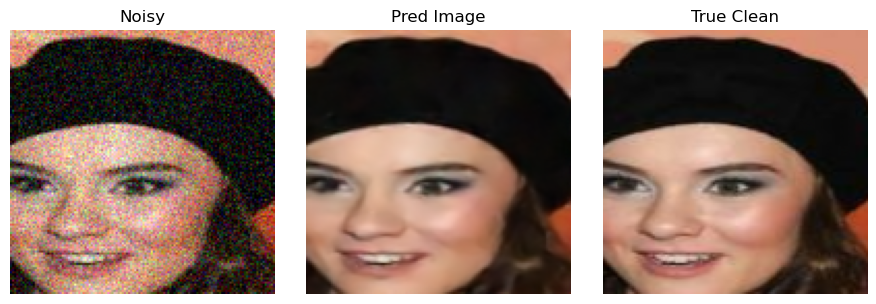

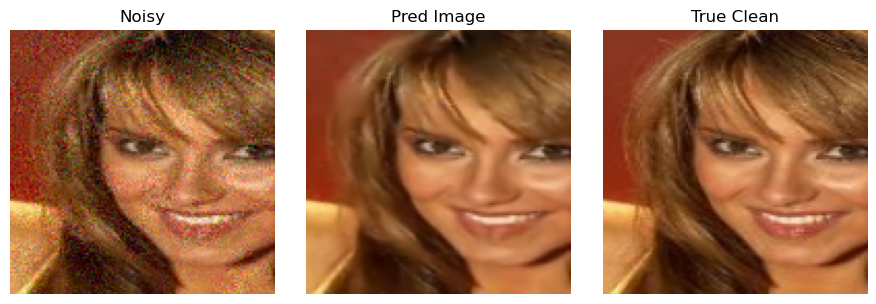

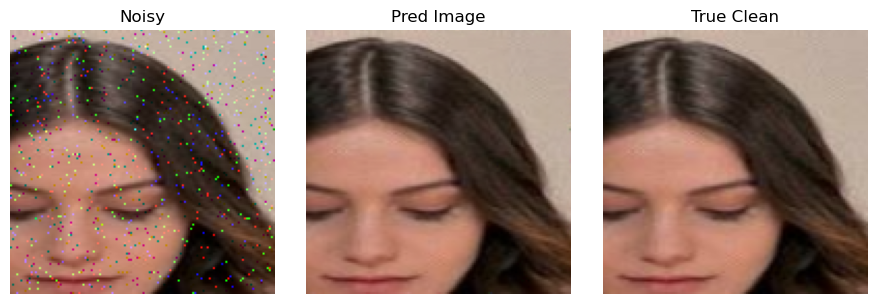

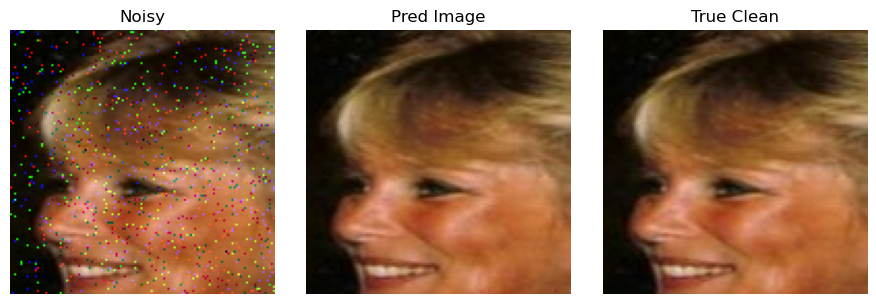

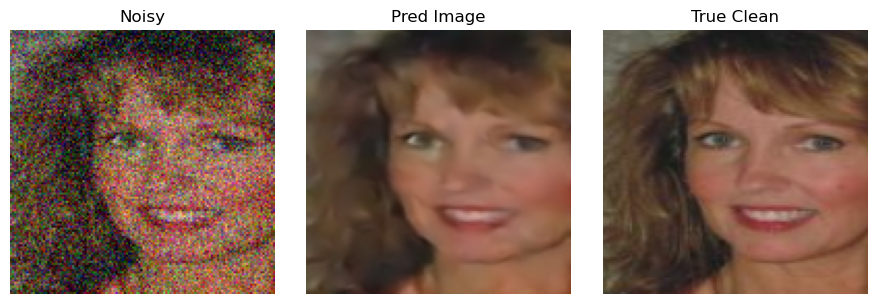

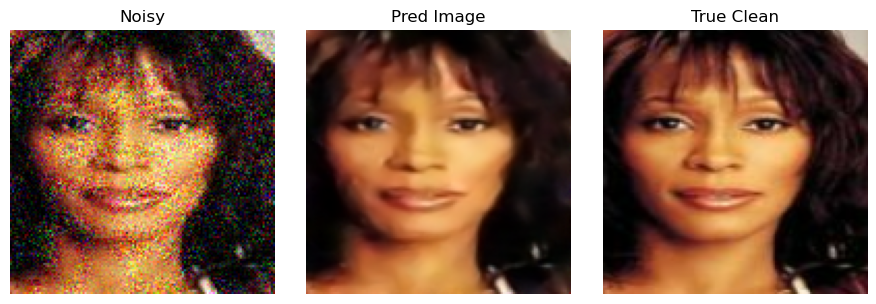

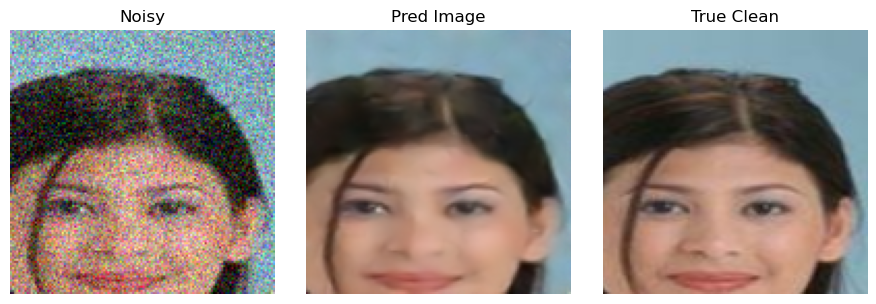

In [17]:
for i in range(0,7):
    plt.figure(figsize=(12,3))

    plt.subplot(1,4,1)
    plt.imshow(tf.clip_by_value(noisy[i], 0, 1))
    plt.title("Noisy")
    plt.axis("off")

    plt.subplot(1,4,2)
    plt.imshow(tf.clip_by_value(pred[i], 0, 1))
    plt.title("Pred Image")
    plt.axis("off")

    plt.subplot(1,4,3)
    plt.imshow(tf.clip_by_value(true[i], 0, 1))
    plt.title("True Clean")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


In [28]:
model.save("rcnn")

INFO:tensorflow:Assets written to: rcnn\assets


INFO:tensorflow:Assets written to: rcnn\assets


In [14]:
model = RCNN()
model.build((None,178,216, 3))
model.load_weights("rcnn/variables/variables")

